In [1]:
# Error with scientific format in plot axes
ENV["GKS_ENCODING"] = "utf8"

using Plots
using Printf
using ProfileVega
using Random
using Revise
using Statistics
using StatsBase    # counts(...)

# The default format SVG creates figures of size 9600x6400
ProfileVega.set_default_size(1200, 800)

Random.seed!(42)

# The default format SVG creates figures of size 9600x6400
gr(fmt="png")
nothing

In [2]:
module RandomLineWalk

import ReinforcementLearningSutton: actions, finished, restart, update
using ReinforcementLearningSutton: GameGridWorldBase, GameGridWorld, I1, T1, Player, game, state, state_set, value

struct RulesetRandomLineWalk
    state_start::I1
    states_goal::Tuple{I1, I1}
    
    function RulesetRandomLineWalk(game0::GameGridWorldBase, pos_start::T1)
        new(state(game0, pos_start), (game0.states[1], game0.states[end]))
    end
end

const GameType = GameGridWorld{GameGridWorldBase{T1, T1}, RulesetRandomLineWalk}

actions(game::GameType, state::I1) = game.game0.actions
finished(game::GameType) = state(game) in game.ruleset.states_goal
restart(game::GameType) = state_set(game, game.ruleset.state_start)

function update(game::GameType, action::I1)::Int
    p = value(state(game))[1] + value(action)[1]
    
    (g_l, g_r) = game.ruleset.states_goal
    if p <= value(g_l)[1]
        state_set(game, g_l)
        -1
    elseif p >= value(g_r)[1]
        state_set(game, g_r)
        1
    else
        state_set(game, game.game0.states[p - value(g_l)[1] + 1])
        0
    end
end

end;

In [3]:
using ReinforcementLearningSutton: GameGridWorldBase, GameGridWorld, PlayerRandom

nstates = 1000
max_jump = 100

game0 = GameGridWorldBase((nstates + 2, ), [map(Tuple, -max_jump:-1); map(Tuple, 1:max_jump)], (0, ))
ruleset = RandomLineWalk.RulesetRandomLineWalk(game0, (Int(nstates / 2), ))
game = GameGridWorld(game0, ruleset)

player = PlayerRandom(game);

#### Get distribution of probabilities, given starting position

In [4]:
using ReinforcementLearningSutton: decide_action, state, state_set, update, value

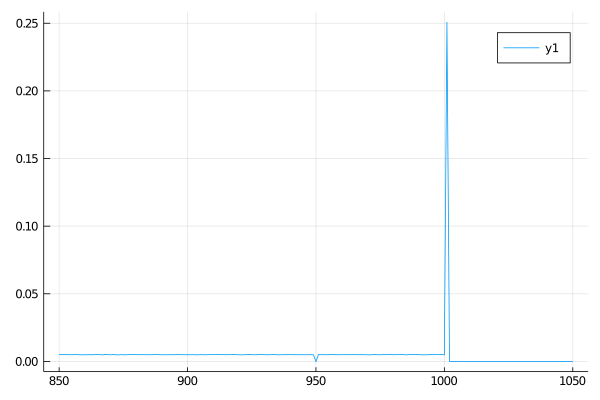

In [5]:
function f(player, initial_pos)
    initial_state = player.game.game0.states[initial_pos + 1]
    state_set(player.game, initial_state)
    update(player.game, decide_action(player))
    value(state(player.game))[1]
end

initial_pos = 950
moves = [f(player, initial_pos) for _ in 1:1000000];
rng = initial_pos-100:initial_pos+100
plot(rng, counts(moves, rng) / 1e6)

#### SGD

In [6]:
using ReinforcementLearningSutton: Histogram, LearningSGDStateAgg, play_game

In [7]:
naggs = 10
agg_index = vcat([0], map(x -> ceil(Int, x), collect(1:nstates) / (nstates / naggs)), [0])
α = 2e-5
γ = 1.
learning = LearningSGDStateAgg(player, agg_index, α, γ)
hist = Histogram(nstates + 2)

max_nsteps = 10000
[play_game(game, player, max_nsteps, (learning, hist)) for _ in 1:1000000];

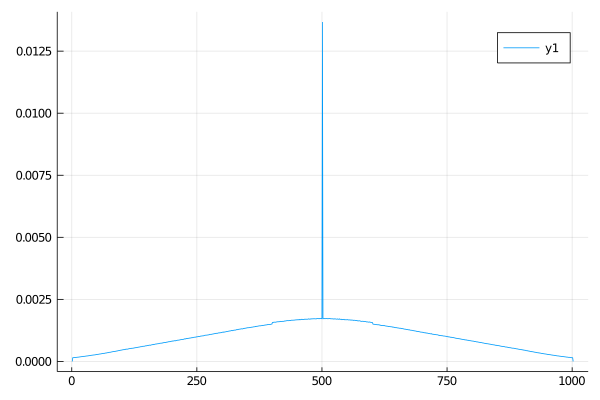

In [8]:
plot(hist.counts / sum(hist.counts))

In [9]:
learning.agg_w

10-element Array{Float64,1}:
 -0.6975825365848033
 -0.48666746104511904
 -0.30973648514529256
 -0.15202010010645367
 -0.008428303959807983
  0.11425632408565208
  0.24115652808148347
  0.38019450150664325
  0.5372682758272728
  0.7262243819641523